# Project: Disaster Tweets 

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified. 

In [1]:
#Loading the necessary libraries 

import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import re

import sklearn 
from sklearn import feature_extraction, model_selection, linear_model

import nltk 
from nltk.corpus import stopwords
from nltk import sent_tokenize
from nltk import word_tokenize

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.utils import to_categorical 
from tensorflow.python.framework.random_seed import set_random_seed

from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## EDA 

First, we look at the dataset. We can see that the two target classes are rather balanced in the training set (*real* disaster tweets: 3271, *fake* disaster tweets: 4342). 

We also observe that the id column doesn't provide any useful information and can be dropped. 

Moreover, analysis on the location column reveals that 30% of values are missing, and those that are there are expressed in a variety of formats (city, state, city+state...). Since location wouldn't probably have helped much our classification, as disasters can unfortunately happen anywhere, we discard this column as well. 

The keyword column seems to be useful, even with missing values. 

In [2]:
#Loading the dataset 

url = 'https://www.math.unipd.it/~dasan/disaster/'
train_df = pd.read_csv(url + 'train.csv', sep=",") 
test_df = pd.read_csv(url + 'test.csv', sep=",") 


# Exploring the dataset 

train_df.shape # The training set has 7613 rows and 5 columns 

train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print("The real disaster tweets are {}".format(len(train_df[train_df['target'] == 1])))
print("The fake disaster tweets are {}".format(len(train_df[train_df['target'] == 0])))
print()
print("Hence, the two classes are balanced, although we have slightly more fake than real tweets")

print("The missing values for the keyword column are: {}".format(train_df["keyword"].isna().sum()))
print("There are {} unique keywords in the dataframe".format(len(train_df["keyword"].unique())))
print()
print("The missing values for the location column are: {}".format(train_df["location"].isna().sum()))
print("There are {} unique locations in the dataframe".format(len(train_df["location"].unique())))
print()
print("""One can already assume that keywords are going to be more relevant than locations for classification, 
      as more than 30% of location values are missing""")

The real disaster tweets are 3271
The fake disaster tweets are 4342

Hence, the two classes are balanced, although we have slightly more fake than real tweets
The missing values for the keyword column are: 61
There are 222 unique keywords in the dataframe

The missing values for the location column are: 2533
There are 3342 unique locations in the dataframe

One can already assume that keywords are going to be more relevant than locations for classification, 
      as more than 30% of location values are missing


In [4]:
train_df['location'].unique()

array([nan, 'Birmingham', 'Est. September 2012 - Bristol', ...,
       'Vancouver, Canada', 'London ', 'Lincoln'], dtype=object)

In [5]:
type(train_df)

pandas.core.frame.DataFrame

In [6]:
# Dropping location column because of too many different location formats and id columns 
# since it gives us no info 

#train_df = train_df.drop('location', axis=1)
train_df = train_df.drop('id', axis=1)
train_df = train_df.drop('location', axis=1)

In [7]:
train_df.head()

,keyword,text,target
0,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Text Preprocessing 

We now turn to preprocess the text of the two columns left, 'text' and 'keyword'. 

Looking at the unique values of 'keyword' column, we can immediately see that there are special characters instead of spaces, so we remove those and put spaces instead. 

We also remove special characters and urls from both columns thanks to utility functions. 

While the column 'text' has no missing values in it, the 'keyword' column does. We set those to 0 and convert to strings. This shouldn't affect our analysis (we will use CountVectorizer and none of the non-missing values have 0 in them so it should create a different token). 

Since CountVectorizer has some very useful parameters, this is all the preprocessing we need. 

In [8]:
train_df['text'].isna().any()

False

In [9]:
train_df['keyword'].unique()

#there are weird characters instead of spaces, quick fix for both test and training set 

train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20',' ')

In [10]:
#train_df['keyword'].unique()

#test_df['keyword'].unique()

In [11]:
# The keyword column actually seems useful, let's keep it 

# Utility functions for cleaning text of tweets 
def url_remover(text):
    text1 = re.sub(r'http?:\/\/.*[\r\n]*', "", text)
    text2 = re.sub(r'https:\/\/.*[\r\n]*', "", text1)
    text3 = " ".join(word for word in text2.split() if not word.startswith('@'))
    return text3.casefold().strip()

def special_chars_remover(text):
    text1 = re.sub(r"[^a-zA\s]", "", text)
    text2 = text1.replace("#", "").strip()
    #text2 = ' '.join(filter(str.isalnum, text2))
    return text2.strip()

# Applying functions to the training and test sets 
train_df['text'] = train_df.text.apply(url_remover)

train_df['text'] = train_df.text.apply(special_chars_remover)


test_df["text"] = test_df.text.apply(url_remover)


test_df["text"] = test_df.text.apply(special_chars_remover)

In [12]:
train_df['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    people receive wildfires evacuation orders in ...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [13]:
test_df['text'].head()

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object

In [14]:
train_df.shape

(7613, 3)

In [15]:
test_df.shape
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


In [16]:
X_train = train_df[['text', 'keyword']]
y_train = train_df['target']

X_test = test_df[['text', 'keyword']]

# Replace nans in keyword columns with zeroes 

X_train['keyword'] = X_train['keyword'].fillna(0)
X_train['keyword'] = X_train['keyword'].astype(str)
X_test['keyword'] = X_test['keyword'].fillna(0)
X_test['keyword'] = X_test['keyword'].astype(str)

<ipython-input-16-af780f71820a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].fillna(0)
<ipython-input-16-af780f71820a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].astype(str)
<ipython-input-16-af780f71820a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [17]:
print("X_train dim after processing: {}".format(X_train.shape))
print("y_train dim after processing: {}".format(y_train.shape))
print("X_test dim after processing: {}".format(X_test.shape))
X_train.head()

X_train dim after processing: (7613, 2)
y_train dim after processing: (7613,)
X_test dim after processing: (3263, 2)


,text,keyword
0,our deeds are the reason of this earthquake ma...,0
1,forest fire near la ronge sask canada,0
2,all residents asked to shelter in place are be...,0
3,people receive wildfires evacuation orders in ...,0
4,just got sent this photo from ruby alaska as s...,0


In [18]:
X_test.head()

,text,keyword
0,just happened a terrible car crash,0
1,heard about earthquake is different cities sta...,0
2,there is a forest fire at spot pond geese are ...,0
3,apocalypse lighting spokane wildfires,0
4,typhoon soudelor kills in china and taiwan,0


In [19]:
# Even if tokenization could just be performed by CountVectorizer, we apply it here
# because it is necessary for lemmatization 

#from nltk.stem.wordnet import WordNetLemmatizer

#from nltk.tokenize import word_tokenize

#lemma_sents=[]
#for i, el in train_df['text'].items():
    #lemma_sents.append(word_tokenize(el))
#print(lemma_sents)

#lemma_sents = pd.Series(lemma_sents)
#train_df['text'] = lemma_sents 

In [20]:
train_df.head()

,keyword,text,target
0,NaN,our deeds are the reason of this earthquake ma...,1
1,NaN,forest fire near la ronge sask canada,1
2,NaN,all residents asked to shelter in place are be...,1
3,NaN,people receive wildfires evacuation orders in ...,1
4,NaN,just got sent this photo from ruby alaska as s...,1


In [21]:
#import nltk 

#nltk.download('wordnet')

#lemmatizer = WordNetLemmatizer()

#lem_sents=[]
#for i, el in train_df['text'].items():
    #lem_sents.append([lemmatizer.lemmatize(words_sent) for words_sent in el])

#print(lem_sents)

In [22]:
#lem_sents = pd.Series(lem_sents)
#train_df['text'] = lem_sents 
#
#train_df['text'][0]

## Tokenization 

In this section, I created two different CountVectorizer() in order to preprocess and tokenize both the column 'text' and the 'keyword' column, using unigrams, bigrams and trigrams for both. 

I then applied simple *Logistic Regression* to the training set (which was split in training and validation with a 70/30 split). *Validation accuracy: 76%*

I tried to lemmatize the text but accuracy actually lowered to 74%. 

I tried using l2 regularization, but it does not improve perfomance. 

In [23]:
count_vectorizer1 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=200,
                                                          stop_words='english')

count_vectorizer2 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=10,
                                                          stop_words='english')

#train_vectors1 = pd.DataFrame(count_vectorizer.fit_transform(X_train['text']))
#train_vectors2 = pd.DataFrame(count_vectorizer.fit_transform(X_train['keyword']))
#X_train = pd.concat([train_vectors1, train_vectors2], axis=1)



In [24]:
# Creating X_train 

train_vectors1 =count_vectorizer1.fit_transform(X_train['text'])

type(train_vectors1)

print("vocabulary of text column is {}".format(count_vectorizer1.vocabulary_))

train_vectors2 = count_vectorizer2.fit_transform(X_train['keyword'])
print()
print()
print("vocabulary of keyword column is {}".format(count_vectorizer2.vocabulary_))

vocabulary of text column is {'earthquake': 47, 'forest': 67, 'near': 121, 'evacuation': 51, 'people': 133, 'california': 23, 'just': 94, 'got': 75, 'photo': 134, 'smoke': 157, 'school': 150, 'flood': 63, 'disaster': 44, 'rain': 138, 'flooding': 64, 'im': 89, 'theres': 169, 'emergency': 48, 'coming': 31, 'area': 2, 'heat': 78, 'getting': 69, 'live': 106, 'gonna': 73, 'ive': 92, 'damage': 36, 'car': 24, 'crash': 34, 'breaking': 19, 'man': 114, 'love': 111, 'summer': 165, 'day': 37, 'shit': 155, 'like': 102, 'end': 49, 'rt': 144, 'set': 153, 'look': 108, 'night': 125, 'new': 123, 'head': 77, 'st': 159, 'police': 137, 'check': 26, 'youre': 199, 'dead': 38, 'time': 173, 'know': 96, 'life': 100, 'year': 197, 'home': 84, 'years': 198, 'black': 11, 'truck': 178, 'city': 27, 'amp': 1, 'fires': 61, 'does': 45, 'dont': 46, 'make': 112, 'work': 192, 'accident': 0, 'great': 76, 'pm': 136, 'god': 71, 'stop': 161, 'th': 167, 'right': 143, 'help': 79, 'today': 175, 'fucking': 68, 'killed': 95, 'going

In [25]:
vocab1 = count_vectorizer1.vocabulary_
vocab2 = count_vectorizer2.vocabulary_

whole_vocab = {**vocab1, **vocab2}

print(whole_vocab)
print(len(vocab1))
print(len(vocab2))
print(len(whole_vocab))

{'earthquake': 47, 'forest': 67, 'near': 121, 'evacuation': 51, 'people': 133, 'california': 23, 'just': 94, 'got': 75, 'photo': 134, 'smoke': 157, 'school': 150, 'flood': 63, 'disaster': 4, 'rain': 138, 'flooding': 64, 'im': 89, 'theres': 169, 'emergency': 5, 'coming': 31, 'area': 2, 'heat': 78, 'getting': 69, 'live': 106, 'gonna': 73, 'ive': 92, 'damage': 36, 'car': 24, 'crash': 34, 'breaking': 19, 'man': 114, 'love': 111, 'summer': 165, 'day': 37, 'shit': 155, 'like': 102, 'end': 49, 'rt': 144, 'set': 153, 'look': 108, 'night': 125, 'new': 123, 'head': 77, 'st': 159, 'police': 137, 'check': 26, 'youre': 199, 'dead': 38, 'time': 173, 'know': 96, 'life': 100, 'year': 197, 'home': 84, 'years': 198, 'black': 11, 'truck': 178, 'city': 27, 'amp': 1, 'fires': 6, 'does': 45, 'dont': 46, 'make': 112, 'work': 192, 'accident': 0, 'great': 76, 'pm': 136, 'god': 71, 'stop': 161, 'th': 167, 'right': 143, 'help': 79, 'today': 175, 'fucking': 68, 'killed': 95, 'going': 72, 'best': 10, 'really': 140

In [26]:
type(train_vectors2)

print(train_vectors1.shape)
print(train_vectors2.shape)

import scipy
from scipy.sparse import coo_matrix, hstack

X_train = scipy.sparse.hstack([train_vectors1, train_vectors2])

(7613, 200)
(7613, 10)


In [27]:
X_train.shape

(7613, 210)

In [28]:
# Creating X_test and y_test

test_vectors1 = count_vectorizer1.transform(X_test['text'])
test_vectors2 = count_vectorizer2.transform(X_test['keyword'])
X_test = scipy.sparse.hstack([test_vectors1, test_vectors2])

X_test.shape


(3263, 210)

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  train_size = 0.7, random_state = 123)

In [30]:
# Let's try scaling our data 

from sklearn.preprocessing import MaxAbsScaler

#define the scaler
scaler = MaxAbsScaler()

#fit the scaler on the training

#trasform the input

X_train_sc = scaler.fit(X_train)
X_train = X_train_sc.transform(X_train)
X_test = X_train_sc.transform(X_test)



## Logistic Regression

In [31]:
from sklearn import linear_model, model_selection


from sklearn.model_selection import GridSearchCV #import the library

param_grid_test = {
    'C': [0.1, 0.5, 1, 5, 10, 15, 20],
    'fit_intercept': [True, False]
}

#target classifier
lr = LogisticRegression(max_iter = 300)

#grid-search object
clf_lr = GridSearchCV(estimator= lr, param_grid=param_grid_test, 
                   cv = 10, scoring = "accuracy")



In [32]:
clf_lr.fit(X_train, y_train)

y_train_pred_lr = clf_lr.predict(X_train)
y_val_pred_lr = clf_lr.predict(X_val)


print(clf_lr.best_params_)
print(clf_lr.best_score_)
print(f"Logistic Regression.\tTrain ACC: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"Logistic Regression.\tVal ACC: {accuracy_score(y_val, y_val_pred_lr)}")

{'C': 5, 'fit_intercept': True}
0.735595437938185
Logistic Regression.	Train ACC: 0.7558641396134359
Logistic Regression.	Val ACC: 0.7338003502626971


In [33]:
# The error above suggests us to scale the data / increase maximum number of iterations (see LAB 3)

#Possible improvements:
#-lemmatization: actually lowers accuracy 
#- scaling: accuracy roughly same (75%)


## KNN

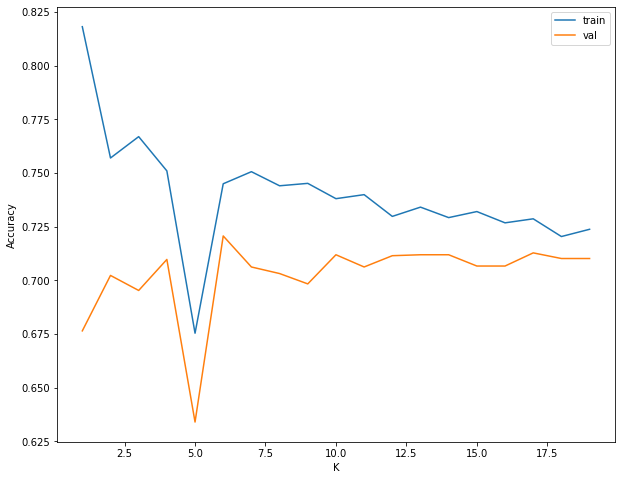

In [34]:

from sklearn.neighbors import KNeighborsClassifier


accuracy_values_train = []
accuracy_values_val = []
k_values = range(1, 20)


for k in k_values:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred_val = model.predict(X_val)
  accuracy_values_train.append(accuracy_score(y_pred_train, y_train))
  accuracy_values_val.append(accuracy_score(y_pred_val, y_val))

    
fig = plt.figure(figsize=(10,8))
plt.plot(k_values, accuracy_values_train, label="train")
plt.plot(k_values, accuracy_values_val, label="val")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#Highest accuracy for KNN is reached with K=6 (on validation set ), but its suboptimal (72%) 


## Decision Trees 

In [35]:
from sklearn import tree

param_grid_test = {
    'max_depth': [50,100,120,150,175,200,300,500],
    'max_features': [100,150,200],
    'min_samples_leaf':[1,3,5,7]
}

#target classifier
tree = tree.DecisionTreeClassifier(criterion='entropy')

#grid-search object
clf_tree = GridSearchCV(estimator= tree, param_grid=param_grid_test, 
                   cv = 10, scoring = "accuracy")


In [36]:
#clf_tree = tree.DecisionTreeClassifier(criterion='entropy') #, min_samples_leaf=15, max_depth=4)
#clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2)
#clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_leaf=2, max_depth=4) # options to control the complexity of the tree while learning
clf_tree.fit(X_train, y_train)

y_train_pred_tree = clf_tree.predict(X_train)
y_val_pred_tree = clf_tree.predict(X_val)

print(f"Decision Tree.\tTrain ACC: {accuracy_score(y_train, y_train_pred_lr)}")
print(f"Decision Tree.\tVal ACC: {accuracy_score(y_val, y_val_pred_lr)}")

Decision Tree.	Train ACC: 0.7558641396134359
Decision Tree.	Val ACC: 0.7338003502626971


In [37]:
sklearn.set_config(print_changed_only=False)

clf_tree

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='entropy',
                                              max_depth=None, max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              random_state=None,
                                              splitter='best'),
             n_jobs=None,
             param_grid={'max_depth': [50, 100, 120, 150, 175, 200, 300, 500],
                         'max_features': [100, 150, 200],
                       

In [38]:
classname = ['no disaster', 'disaster']

vocab = list(whole_vocab.keys())
print(vocab)

['earthquake', 'forest', 'near', 'evacuation', 'people', 'california', 'just', 'got', 'photo', 'smoke', 'school', 'flood', 'disaster', 'rain', 'flooding', 'im', 'theres', 'emergency', 'coming', 'area', 'heat', 'getting', 'live', 'gonna', 'ive', 'damage', 'car', 'crash', 'breaking', 'man', 'love', 'summer', 'day', 'shit', 'like', 'end', 'rt', 'set', 'look', 'night', 'new', 'head', 'st', 'police', 'check', 'youre', 'dead', 'time', 'know', 'life', 'year', 'home', 'years', 'black', 'truck', 'city', 'amp', 'fires', 'does', 'dont', 'make', 'work', 'accident', 'great', 'pm', 'god', 'stop', 'th', 'right', 'help', 'today', 'fucking', 'killed', 'going', 'best', 'really', 'screaming', 'bloody', 'face', 'way', 'want', 'say', 'need', 'debris', 'good', 'state', 'wreck', 'times', 'little', 'looks', 'house', 'cause', 'come', 'services', 'destroy', 'blood', 'run', 'news', 'said', 'hes', 'body', 'hit', 'train', 'thats', 'weather', 'army', 'food', 'wild', 'world', 'save', 'survive', 'boy', 'watch', 'feel

In [39]:
# Can't visualize the tree :(

## Neural Networks

Unfortunately, Decision trees don't seem to improve perfomance (we are still around 75%). 

So we try neural nets, but first reload all code in order for it to be adaptable to nns. 

In [40]:
#Loading the dataset 

url = 'https://www.math.unipd.it/~dasan/disaster/'
train_df = pd.read_csv(url + 'train.csv', sep=",") 
test_df = pd.read_csv(url + 'test.csv', sep=",") 

train_df = train_df.drop('id', axis=1)
train_df = train_df.drop('location', axis=1)


train_df['keyword'] = train_df['keyword'].str.replace('%20',' ')
test_df['keyword'] = test_df['keyword'].str.replace('%20',' ')

# The keyword column actually seems useful, let's keep it 

# Utility functions for cleaning text of tweets 
def url_remover(text):
    text1 = re.sub(r'http?:\/\/.*[\r\n]*', "", text)
    text2 = re.sub(r'https:\/\/.*[\r\n]*', "", text1)
    text3 = " ".join(word for word in text2.split() if not word.startswith('@'))
    return text3.casefold().strip()

def special_chars_remover(text):
    text1 = re.sub(r"[^a-zA\s]", "", text)
    text2 = text1.replace("#", "").strip()
    #text2 = ' '.join(filter(str.isalnum, text2))
    return text2.strip()

# Applying functions to the training and test sets 
train_df['text'] = train_df.text.apply(url_remover)

train_df['text'] = train_df.text.apply(special_chars_remover)


test_df["text"] = test_df.text.apply(url_remover)


test_df["text"] = test_df.text.apply(special_chars_remover)


X_train = train_df[['text', 'keyword']]
y_train = train_df['target']

X_test = test_df[['text', 'keyword']]

# Replace nans in keyword columns with zeroes 

X_train['keyword'] = X_train['keyword'].fillna(0)
X_train['keyword'] = X_train['keyword'].astype(str)
X_test['keyword'] = X_test['keyword'].fillna(0)
X_test['keyword'] = X_test['keyword'].astype(str)

<ipython-input-40-856d0c30b883>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].fillna(0)
<ipython-input-40-856d0c30b883>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['keyword'] = X_train['keyword'].astype(str)
<ipython-input-40-856d0c30b883>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [41]:
count_vectorizer1 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=200,
                                                          stop_words='english')

count_vectorizer2 = feature_extraction.text.CountVectorizer(ngram_range=(1,3), max_features=10,
                                                          stop_words='english')

train_vectors1 =count_vectorizer1.fit_transform(X_train['text'])
train_vectors2 = count_vectorizer2.fit_transform(X_train['keyword'])

vocab1 = count_vectorizer1.vocabulary_
vocab2 = count_vectorizer2.vocabulary_

whole_vocab = {**vocab1, **vocab2}




test_vectors1 = count_vectorizer1.transform(X_test['text'])
test_vectors2 = count_vectorizer2.transform(X_test['keyword'])

import scipy
from scipy.sparse import coo_matrix, hstack

X_train = scipy.sparse.hstack([train_vectors1, train_vectors2])

X_test = scipy.sparse.hstack([test_vectors1, test_vectors2])

from scipy.sparse import csr_matrix

X_train = csr_matrix(X_train).toarray()
X_test = csr_matrix(X_test).toarray()

print("X train shape: {}".format(X_train.shape))
print("X test shape: {}".format(X_test.shape))



X train shape: (7613, 210)
X test shape: (3263, 210)


In [42]:
feature_vector_length = 210
num_classes = 2


print(y_train)

y_train_nn = np.where(y_train==0, -1, y_train) 

type(y_train_nn)
np.unique(y_train_nn)

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64


array([-1,  1], dtype=int64)

In [48]:
X_train.shape
y_train.shape

(7613,)

In [49]:
# Configuration options
#see the number of labels
labels = set(y_train)
print(labels, len(labels))

{0, 1} 2


In [51]:
# Configuration options
feature_vector_length = X_train.shape[1] #how many features
num_classes = len(labels) #how many classes

print(feature_vector_length, num_classes)

y_train_cat = to_categorical(y_train, num_classes)

210 2


In [52]:
np.random.seed(123)
set_random_seed(2)

model = Sequential() #we first define how the "model" looks like
model.add(Dense(input_dim = feature_vector_length, units=feature_vector_length , activation='relu')) #input layer
model.add(Dense(num_classes, activation='softmax')) #output layer
print(model.summary())
#plot_model(model, show_shapes= True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 210)               44310     
                                                                 
 dense_3 (Dense)             (None, 2)                 422       
                                                                 
Total params: 44,732
Trainable params: 44,732
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
model.compile(loss='categorical_crossentropy', #loss metric
    optimizer='sgd',  #optimizer
    metrics=['accuracy']) #displayed metric


#fit
history = model.fit(X_train, y_train_cat, epochs=5, batch_size=8, verbose=1, validation_split=0.1)

Epoch 1/5
857/857 [==============================] - 5s 5ms/step - loss: 0.6677 - accuracy: 0.6043 - val_loss: 0.6496 - val_accuracy: 0.6575
Epoch 2/5
857/857 [==============================] - 2s 2ms/step - loss: 0.6348 - accuracy: 0.6679 - val_loss: 0.6191 - val_accuracy: 0.6969
Epoch 3/5
857/857 [==============================] - 2s 2ms/step - loss: 0.6072 - accuracy: 0.6922 - val_loss: 0.5889 - val_accuracy: 0.7441
Epoch 4/5
857/857 [==============================] - 2s 2ms/step - loss: 0.5833 - accuracy: 0.7192 - val_loss: 0.5669 - val_accuracy: 0.7428
Epoch 5/5
857/857 [==============================] - 3s 4ms/step - loss: 0.5652 - accuracy: 0.7307 - val_loss: 0.5512 - val_accuracy: 0.7480


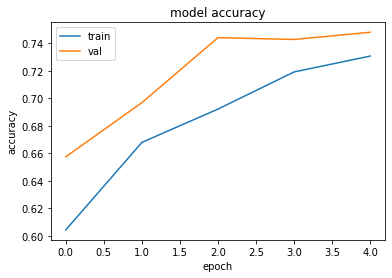

In [54]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# plt.ylim(0.8, 1)
plt.show()

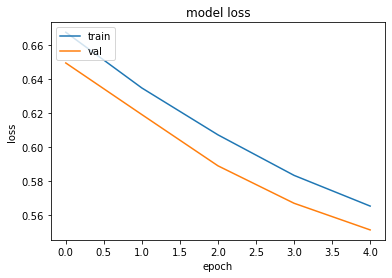

In [55]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [87]:


def MLP_definer2(n_layers, input_size, n_classes):
    #seed
    np.random.seed(123)
    set_random_seed(2)
    
    #define a sequential model
    model = Sequential()

    if n_layers == 0:
        model.add(Dense(input_dim= input_size, units = input_size, activation= 'softmax'))
    else:
        #define the first layer 
        for i in range(n_layers):
            if i == 0: #input layer
                model.add(Dense(units = input_size, input_dim = input_size, activation='relu'))
            else:
                model.add(Dense(units = (input_size*2)/3, activation = 'relu'))

    model.add(Dense(units = n_classes, activation= 'sigmoid'))

    # Configure the model and start training
    model.compile(loss='categorical_crossentropy', #loss metric
              optimizer='sgd',  #optimizer
              metrics=['accuracy']) #displayed metric

    return model

In [88]:
nlayers = [0,1,2]

for nl in nlayers:
    #create the MLP
    m = MLP_definer2(n_layers= nl, input_size=feature_vector_length, n_classes= 2)
    print(m.summary())

    #train our model
h = m.fit(X_train, y_train_cat, epochs=500, 
          batch_size=50, verbose=0, validation_split=0.15, 
          callbacks=[es])
print(f"N layers:{nl}\t\tTrain ACC:{h.history['accuracy'][-1]:.8f}\tVal ACC:{h.history['val_accuracy'][-1]:.8f}")
    
print("\n\n\n\n")

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_200 (Dense)           (None, 210)               44310     
                                                                 
 dense_201 (Dense)           (None, 2)                 422       
                                                                 
Total params: 44,732
Trainable params: 44,732
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 210)               44310     
                                                                 
 dense_203 (Dense)           (None, 2)                 422       
                                                                 
Total params: 44,732


In [ ]:
# Reached 71% accuracy with neural net 
# Surely, can be improved by 
# - choosing better the activation fucntion and n of neurons in each layer 
# - preprocessing better the text data 
# - changing the n of layers 
# - changing type of layers? 